The links generate power, this is because the efficiency losses are only considered at node2 of the link, independet of the direction of the flow, thus, if energy flows into the opposite direction, 1/efficiency energy is injected at that node. This is crucial fopr 

In [2]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, res_capacity_atlite, region_plotting
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")
#warnings.filterwarnings("ignore", category=UserWArning, message="warnings.filterwarnings("ignore", category=FutureWarning, message="

In [3]:
# SYNTHETIC -> excludes Europe and USA
path = "/Volumes/fi246disk/synde/resources/gegis/output"
load_profile_dic = {}
for key, value in regions_dic.items():
    load_profile_dic[key] = {}
    if key != "north_america" and key != "europe" and key != "alaska":
        load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" )

# HISTORIC -> includes Europe and USA
demand_mult_ssp1_26_oecd = 1.36
load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
synthetic_load_north_america_no_usa = syntheticdemand_gis(path, "north_america_no_usa", "ssp1-26")
load_profile_dic["north_america"]["load"] = historic_load_usa + synthetic_load_north_america_no_usa

res_potential_dic = {}
for key, value in regions_dic.items():
    #if key != "oceania": #and key != "south_asia" and key != "middle_east" and key != "europe" and key != "north_africa":
    res_potential_dic[key] = {}
    res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=5, land_available=0.08)
    res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=0.05)
        

In [4]:
# Define the snapshots
snapshots = pd.date_range("2050-01-01", periods=3, freq="h")
# Renewable energy potential time series
# res_potential_node1 = pd.Series([2, 8, 4, 2, 8, 4], index=snapshots)
# res_potential_node2 = pd.Series([2, 2, 2, 2, 8, 4], index=snapshots)
# res_potential_node1_PV = pd.Series([1, 3, 1, 5, 2, 3], index=snapshots)
# res_potential_node2_PV = pd.Series([0, 3, 4, 6, 8, 3], index=snapshots)
res_potential_node1 = res_potential_dic['north_america']['wind'][snapshots]
res_potential_node2 = res_potential_dic['europe']['wind'][snapshots]
res_potential_node3 = res_potential_dic['north_africa']['wind'][snapshots]
# Demand time series
# demand_node1 = pd.Series([2, 4, 2, 1, 1, 1], index=snapshots)
# demand_node2 = pd.Series([1, 1, 1, 1, 1, 1], index=snapshots)
demand_node1 = load_profile_dic['north_america']['load'][snapshots]
demand_node2 = load_profile_dic['europe']['load'][snapshots]
demand_node3 = load_profile_dic['north_africa']['load'][snapshots]
print('Surpplus: ',demand_node1 - res_potential_node1, demand_node2 - res_potential_node2, demand_node3 -res_potential_node3)

Surpplus:  2050-01-01 00:00:00   -4.753615e+06
2050-01-01 01:00:00   -5.098593e+06
2050-01-01 02:00:00   -5.273372e+06
dtype: float64 2050-01-01 00:00:00   -2.439115e+06
2050-01-01 01:00:00   -2.412076e+06
2050-01-01 02:00:00   -2.411960e+06
dtype: float64 2050-01-01 00:00:00   -1.185666e+06
2050-01-01 01:00:00   -1.188366e+06
2050-01-01 02:00:00   -1.187514e+06
Freq: h, dtype: float64


In [46]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pypsa


# Create a new network
n = pypsa.Network()

# Define the snapshots
snapshots = pd.date_range("2023-01-01", periods=3, freq="h")
n.set_snapshots(snapshots)

# Add buses
n.add("Bus", "node1", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95, v_mag_pu_max=1.05)
n.add("Bus", "node2", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95, v_mag_pu_max=1.05)
n.add("Bus", "node3", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)
n.add("Bus", "node4", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)


# Renewable energy potential time series
# res_potential_node1 = pd.Series([2, 8, 4, 2, 8, 4], index=snapshots)
# res_potential_node2 = pd.Series([2, 2, 2, 2, 8, 4], index=snapshots)
# res_potential_node1_PV = pd.Series([1, 3, 1, 5, 2, 3], index=snapshots)
# res_potential_node2_PV = pd.Series([0, 3, 4, 6, 8, 3], index=snapshots)
res_potential_node1 = pd.Series([2, 8, 4], index=snapshots)
res_potential_node2 = pd.Series([2, 2, 2], index=snapshots)
res_potential_node3 = pd.Series([5, 3, 7], index=snapshots)

# Demand time series
# demand_node1 = pd.Series([2, 4, 2, 1, 1, 1], index=snapshots)
# demand_node2 = pd.Series([1, 1, 1, 1, 1, 1], index=snapshots)
demand_node1 = pd.Series([2, 4, 2], index=snapshots)
demand_node2 = pd.Series([1, 1, 1], index=snapshots)
demand_node3 = pd.Series([0, 6, 8], index=snapshots)

statement = True
# Add renewable generators with fixed production according to potential
n.add("Generator", "res_node1", bus="node1", type="Wind", p_nom_extendable=statement, p_nom_max = 1, p_max_pu=res_potential_node1, p_min_pu=res_potential_node1,marginal_cost=2, capital_cost=2)
n.add("Generator", "res_node2", bus="node2", type="Wind", p_nom_extendable=statement,p_nom_max = 1, p_max_pu=res_potential_node2, p_min_pu=res_potential_node2, marginal_cost=2, capital_cost=2)
n.add("Generator", "res_node3", bus="node3", type="Wind", p_nom_extendable=statement, p_nom_max = 1, p_max_pu=res_potential_node2, p_min_pu=res_potential_node2,marginal_cost=2, capital_cost=2)
n.add("Generator", "res_node4", bus="node4", type="Wind", p_nom_extendable=statement, p_nom_max = 1, p_max_pu=res_potential_node3, p_min_pu=res_potential_node3,marginal_cost=2, capital_cost=2)

# Add loads
n.add("Load", "load_node1", bus="node1", p_set=demand_node1)
n.add("Load", "load_node2", bus="node2", p_set=demand_node2)
n.add("Load", "load_node3", bus="node3", p_set=demand_node2)
n.add("Load", "load_node4", bus="node4", p_set=demand_node3)

# Add a transmission line (link) between the nodes
n.add("Link", "link_node1_node2", bus0="node1", bus1="node2", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
n.add("Link", "link_node2_node1", bus0="node2", bus1="node1", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
n.add("Link", "link_node1_node3", bus0="node1", bus1="node3", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
n.add("Link", "link_node3_node1", bus0="node3", bus1="node1", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
n.add("Link", "link_node2_node3", bus0="node2", bus1="node3", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
n.add("Link", "link_node3_node2", bus0="node3", bus1="node2", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
n.add("Link", "link_node4_node3", bus0="node4", bus1="node3", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
n.add("Link", "link_node3_node4", bus0="node3", bus1="node4", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
# n.add("Link", "link_node4_node2", bus0="node4", bus1="node2", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)
# n.add("Link", "link_node2_node4", bus0="node2", bus1="node4", p_nom_extendable=True, efficiency=0.9, marginal_cost = 1)

# Add curtailment generators with high marginal cost to penalize excess generation
curtailment_cost = 0  # High cost to penalize curtailment
n.add("Generator", "curtailment_node1", bus="node1", type='Curtailment', p_nom_extendable=True,marginal_cost=curtailment_cost, sign=-1)
n.add("Generator", "curtailment_node2", bus="node2", type='Curtailment', p_nom_extendable=True, marginal_cost=curtailment_cost, sign=-1)
n.add("Generator", "curtailment_node3", bus="node3", type='Curtailment', p_nom_extendable=True, marginal_cost=curtailment_cost, sign=-1)
n.add("Generator", "curtailment_node4", bus="node4", type='Curtailment', p_nom_extendable=True, marginal_cost=curtailment_cost, sign=-1)

m = n.optimize.create_model();


n.optimize(solver_name='highs')

# Print the results
print(n.generators.p_nom_opt)
print(n.generators_t.p)
print(n.loads_t.p_set)
print(n.links_t.p0)
print(n.links_t.p1)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 64 primals, 128 duals
Objective: 8.44e+01
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


Running HiGHS 1.7.1 (git hash: 0c240d8): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 8e+00]
  Cost   [1e+00, 2e+00]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 8e+00]
Presolving model
36 rows, 52 cols, 120 nonzeros  0s
24 rows, 40 cols, 144 nonzeros  0s
12 rows, 40 cols, 72 nonzeros  0s
10 rows, 34 cols, 62 nonzeros  0s
Presolve : Reductions: rows 10(-118); columns 34(-30); elements 62(-186)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         13     8.4404938272e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 13
Objective value     :  8.4404938272e+01
HiGHS run time      :          0.00
Generator
res_node1            1.000000
res_node2            0.500000
res_node3            0.366667
res_node4            1.000000
curtailment_node1    0.469136
curt

In [50]:
# THIS WORKS, NEXT STEP IS TO PLOT IT
balances = []
outflows = []
generations = []
loads = []
slacks = []
curtailments = []
netflows = []
inflows = []
for snapshot in snapshots:
    buses = []
    balances_ = []
    outflows_ = []
    generations_ = []
    curtailments_ = []
    inflows_ = []
    netflows_ = []
    loads_ = []
    for bus in n.buses.index:
        vre_generators = n.generators[(n.generators['bus'] == bus) & ((n.generators['type'] == "Wind") | (n.generators['type'] == "PV"))]
        cur_generators = n.generators[(n.generators['bus'] == bus) & (n.generators['type'] == "Curtailment")]
        vre_p = n.generators_t.p.loc[snapshot, vre_generators.index].sum()
        cur_p = n.generators_t.p.loc[snapshot, cur_generators.index].sum()
        outflow = 0
        inflow = 0
        load = n.loads_t.p_set.loc[snapshot][f'load_{bus}']
        for link in n.links.index:
            if bus == n.links["bus0"][link]:
                outflow -= n.links_t.p0.loc[snapshot][link]
            if bus == n.links["bus1"][link]:
                inflow -= n.links_t.p1.loc[snapshot][link]
            netflow = outflow + inflow
        balance = vre_p - load - cur_p + netflow
        balances_.append(balance)
        outflows_.append(outflow)
        inflows_.append(inflow)
        netflows_.append(netflow)
        generations_.append(vre_p)
        curtailments_.append(cur_p)
        loads_.append(load)
    balances.append(balances_)
    outflows.append(outflows_)
    inflows.append(inflows_)
    generations.append(generations_)
    curtailments.append(curtailments_)
    loads.append(loads_)
    netflows.append(netflows_)

In [51]:
# Convert lists to numpy arrays for easier indexing
balances = np.array(balances)
outflows = np.array(outflows) 
inflows = np.array(inflows)
netflows = np.array(netflows)
generations = np.array(generations)
curtailments = np.array(curtailments)
loads = np.array(loads)
total_balance = np.sum(generations) - np.sum(curtailments)- np.sum(loads)
print('Total balance:',total_balance)

Total balance: 1.0271604938271608


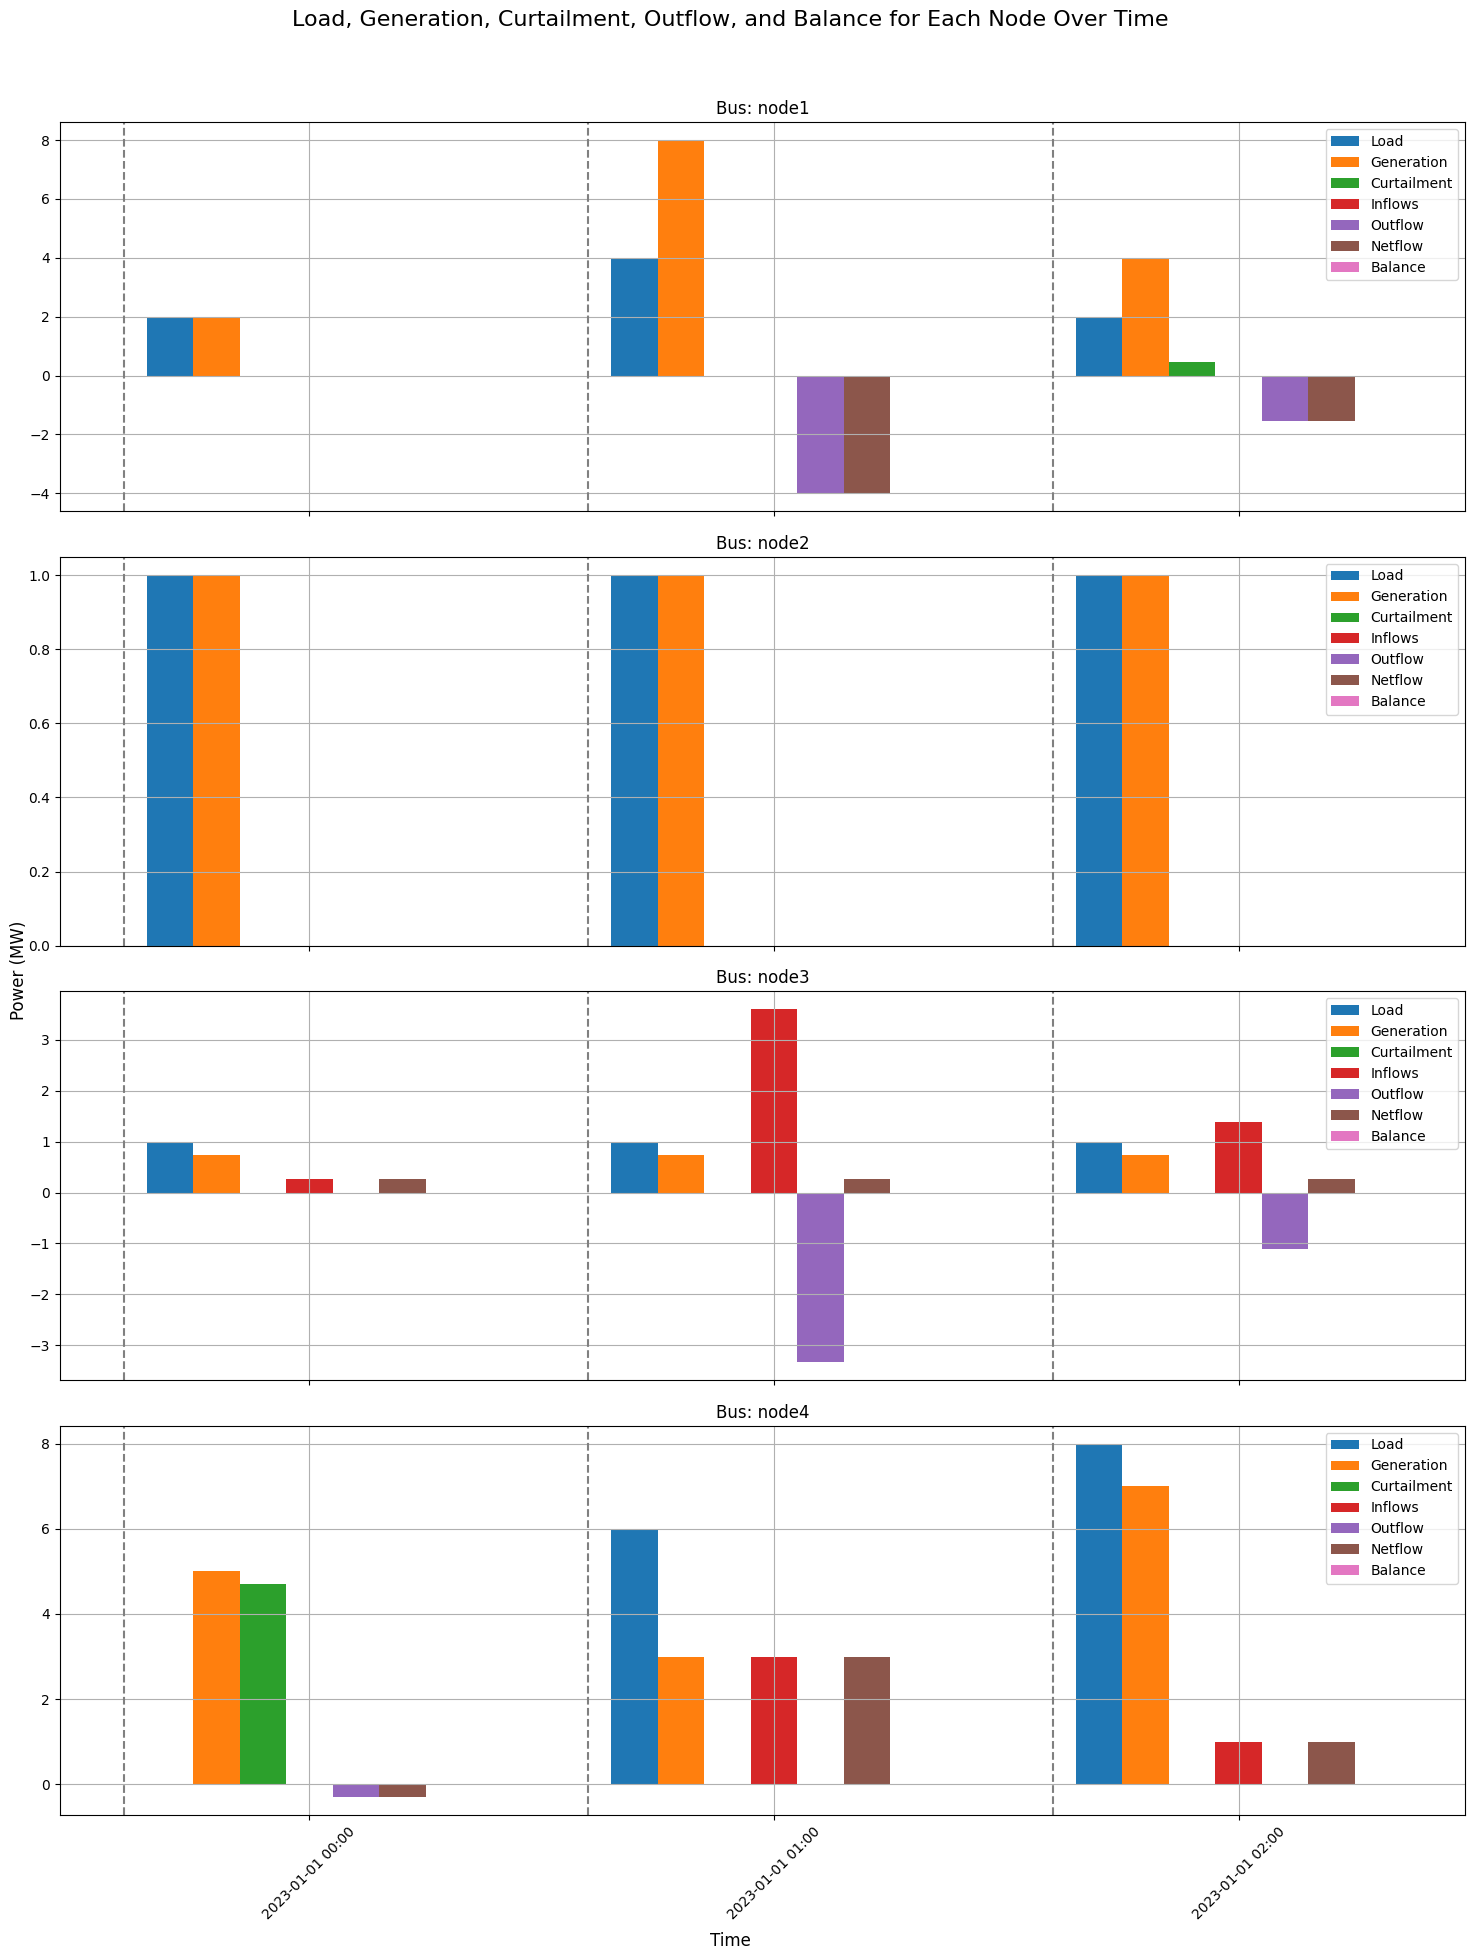

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure all sublists have the same length
num_buses = len(n.buses.index)

# Number of snapshots
num_snapshots = len(snapshots)

# Create subplots for each bus
fig, axes = plt.subplots(num_buses, 1, figsize=(15, num_buses * 5), sharex=True)

# If there's only one bus, make sure axes is iterable
if num_buses == 1:
    axes = [axes]

# Plot data for each bus
bar_width = 0.1  # Adjust bar width to fit all bars within each time step
for i, bus in enumerate(n.buses.index):
    ax = axes[i]
    indices = np.arange(num_snapshots)
    
    # Calculate total width for all bars
    total_width = 6 * bar_width  # 6 because we have 6 types of data to plot

    # Plot load
    ax.bar(indices - total_width/2 + 0 * bar_width, loads[:, i], bar_width, label='Load')
    
    # Plot generation
    ax.bar(indices - total_width/2 + 1 * bar_width, generations[:, i], bar_width, label='Generation')

    # Plot curtailment
    ax.bar(indices - total_width/2 + 2 * bar_width, curtailments[:, i], bar_width, label='Curtailment')
    
    # Plot inflows
    ax.bar(indices - total_width/2 + 3 * bar_width, inflows[:, i], bar_width, label='Inflows')

    # Plot outflows
    ax.bar(indices - total_width/2 + 4 * bar_width, outflows[:, i], bar_width, label='Outflow')

    # Plot netflows
    ax.bar(indices - total_width/2 + 5 * bar_width, netflows[:, i], bar_width, label='Netflow')
    
    # Plot balances
    ax.bar(indices - total_width/2 + 6 * bar_width, balances[:, i], bar_width, label='Balance')
    
    # Add vertical lines to separate time steps
    for idx in indices:
        ax.axvline(x=idx - total_width/2 - bar_width, color='gray', linestyle='--')

    ax.set_title(f"Bus: {bus}")
    ax.set_xticks(indices)
    ax.set_xticklabels(snapshots.strftime('%Y-%m-%d %H:%M'), rotation=45)
    ax.legend()
    ax.grid(True)

# Set overall plot title and labels
fig.suptitle('Load, Generation, Curtailment, Outflow, and Balance for Each Node Over Time', fontsize=16)
fig.supxlabel('Time')
fig.supylabel('Power (MW)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [1]:
print('test')

test
